In [1]:
import kagglehub
import shutil
from pathlib import Path

# Kaggle dataset: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
DATASET = "mohamedbakhet/amazon-books-reviews"

def main():
    print(f"[INFO] Downloading dataset: {DATASET}")
    path = kagglehub.dataset_download(DATASET)
    print("Downloaded to:", path)

    # Copy data to local ./data directory for consistency
    target_dir = Path("data")
    target_dir.mkdir(exist_ok=True)

    print(f"[INFO] Copying files to {target_dir}/")
    for item in Path(path).iterdir():
        dest = target_dir / item.name
        if item.is_file():
            shutil.copy(item, dest)
        elif item.is_dir():
            shutil.copytree(item, target_dir / item.name, dirs_exist_ok=True)

    print("\n[✔] Done. Dataset files are now available in ./data")

if __name__ == "__main__":
    main()

[INFO] Downloading dataset: mohamedbakhet/amazon-books-reviews


100%|██████████| 1.06G/1.06G [00:10<00:00, 105MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/mohamedbakhet/amazon-books-reviews/versions/1
[INFO] Copying files to data/

[✔] Done. Dataset files are now available in ./data


#Create the spark session

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StringType, BooleanType, IntegerType, DoubleType, NumericType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
import pandas as pd
import numpy as np

In [13]:
import os
import findspark
from pyspark.sql import SparkSession
import glob

# --- CONFIGURAZIONE ADATTIVA E AVVIO ---

# 1. Impostazione JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# 2. TROVAZIONE DEL PERCORSO SPARK EFFETTIVO
# Cerchiamo la cartella scompattata nel content (il nome inizia con spark-3.5.1)
# Questo gestisce sia la singola che la doppia cartella di estrazione.
spark_dirs = glob.glob('/content/spark-3.5.1*/')

if spark_dirs:
    # La cartella di Spark è la prima trovata (dovrebbe essercene solo una)
    # Rimuoviamo lo slash finale per un percorso pulito
    SPARK_DIR_ROOT = spark_dirs[0].rstrip('/')

    # Verifichiamo se Spark è in una sottocartella (caso Colab più frequente)
    # Verifichiamo se bin/spark-submit è direttamente sotto la root trovata
    if os.path.exists(f"{SPARK_DIR_ROOT}/bin/spark-submit"):
        # Percorso singolo
        os.environ["SPARK_HOME"] = SPARK_DIR_ROOT
        print(f"SPARK_HOME impostato su: {SPARK_DIR_ROOT}")
    elif os.path.exists(f"{SPARK_DIR_ROOT}/{SPARK_DIR_ROOT.split('/')[-1]}/bin/spark-submit"):
        # Percorso doppio (come avevamo precedentemente ipotizzato)
        os.environ["SPARK_HOME"] = f"{SPARK_DIR_ROOT}/{SPARK_DIR_ROOT.split('/')[-1]}"
        print(f"SPARK_HOME impostato su: {os.environ['SPARK_HOME']}")
    else:
         raise FileNotFoundError("❌ Impossibile trovare bin/spark-submit. L'estrazione ha avuto un problema di struttura.")
else:
    raise FileNotFoundError("❌ Impossibile trovare la cartella radice di Spark.")

findspark.init()

# 3. Avvio della Spark Session
try:
    spark = SparkSession.builder \
        .appName("SPARK-BASICS") \
        .master("local[*]") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

    print("\n🎉 SparkSession avviata con successo!")
    print(f"Versione Spark in uso: {spark.version}")

except Exception as e:
    print(f"\n❌ Errore nell'avvio finale: {e}")

SPARK_HOME impostato su: /content/spark-3.5.1-bin-hadoop3

🎉 SparkSession avviata con successo!
Versione Spark in uso: 3.5.1


In [14]:
num_cores = spark.sparkContext.defaultParallelism
print(f"Spark is using {num_cores} cores.")

Spark is using 2 cores.


In [15]:
spark.conf.set("spark.sql.adaptive.enabled", "true")
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")

#Data Understanding

In [17]:
df_rating = spark.read.csv('/content/data/Books_rating.csv', header=True, inferSchema=True)
df_books = spark.read.csv('/content/data/books_data.csv', header=True, inferSchema=True)


#FIRST:analize the book dataset

In [18]:
df_books.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Title|         description|             authors|               image|         previewLink|           publisher|       publishedDate|            infoLink|          categories|        ratingsCount|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Its Only Art If I...|                NULL|    ['Julie Strain']|http://books.goog...|http://books.goog...|                NULL|                1996|http://books.goog...|['Comics & Graphi...|                NULL|
|Dr. Seuss: Americ...|"Philip Nel takes...| like that of Lew...| has changed lang...| giving us new wo...| inspiring artist...|      ['Philip Nel']|http

In [19]:
# Print the schema of the DataFrame
df_books.printSchema()

root
 |-- Title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- image: string (nullable = true)
 |-- previewLink: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- infoLink: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- ratingsCount: string (nullable = true)



In [22]:
for col_name in df_books.columns:
    print(f"The column '{col_name}' has {df_books.select(col_name).distinct().count()} unique values.")

The column 'Title' has 212400 unique values.
The column 'description' has 133257 unique values.
The column 'authors' has 133019 unique values.
The column 'image' has 149421 unique values.
The column 'previewLink' has 186014 unique values.
The column 'publisher' has 34265 unique values.
The column 'publishedDate' has 28948 unique values.
The column 'infoLink' has 180644 unique values.
The column 'categories' has 28362 unique values.
The column 'ratingsCount' has 16102 unique values.


In [23]:
df_books.describe()

DataFrame[summary: string, Title: string, description: string, authors: string, image: string, previewLink: string, publisher: string, publishedDate: string, infoLink: string, categories: string, ratingsCount: string]

In [24]:
#Check if there are any missing values
df_books.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_books.columns]).show()

+-----+-----------+-------+-----+-----------+---------+-------------+--------+----------+------------+
|Title|description|authors|image|previewLink|publisher|publishedDate|infoLink|categories|ratingsCount|
+-----+-----------+-------+-----+-----------+---------+-------------+--------+----------+------------+
|    1|      68357|  31251|51191|      24055|    73130|        25844|   24301|     40524|      148552|
+-----+-----------+-------+-----+-----------+---------+-------------+--------+----------+------------+



In [25]:
#Check for outliers
df_books.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|               Title|         description|             authors|               image|         previewLink|           publisher|       publishedDate|            infoLink|          categories|        ratingsCount|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              212403|              144047|              181153|              161213|              188349|              139274|              186560|              188103|              171880|               63852|
|   mean|   3823.672941176471|  1.4285714285714286|              1578.4|              1184.0|            Infinity|      

In [29]:
#Distribution of the target variable 'fraud_bool'
df_books.groupBy('categories').count().show()

#Print the distribution in percentage
df_books.groupBy('categories').count().withColumn('percentage', col('count') / df_books.count() * 100).show()

+----------------------+-----+
|            categories|count|
+----------------------+-----+
|   Toronto Globe an...|    1|
|       ['Arboviruses']|    1|
|  "[""Children's so...|   11|
|   Gopnik shows tha...|    1|
|  ['Melanchthon, Ph...|    1|
|   and always naked...|    1|
|       ['Contentment']|    1|
|          ['Barbados']|    2|
|  https://play.goog...|    1|
|       ['Art, Modern']|   15|
|   the Kongo of Low...|    1|
|  http://books.goog...|    1|
|  ['Boats and boati...|   28|
| this fact. ▷ 참고:...|    1|
|   ['Economic policy']|    4|
|  ['Anthracite coal...|    2|
|   Washington State...|    1|
|            2019-08-22|    1|
|  ['Gettysburg (Pa.)']|    1|
|                 beans|    1|
+----------------------+-----+
only showing top 20 rows

+----------------------+-----+--------------------+
|            categories|count|          percentage|
+----------------------+-----+--------------------+
|   Toronto Globe an...|    1|4.708009265362234E-4|
|       ['Arboviruses']|

In [31]:
from pyspark.sql.functions import col, isnull, sum, countDistinct

print("--- Dataset Quality Analysis (Descending Order) ---")

# --- A. Count of Null Values (Descending Order) ---

print("\n## 1. Null Value Count per Column")
print(" (Columns with the most missing values will appear first)")

# Calculate the total number of null values for each column
null_counts = df_books.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in df_books.columns]
).collect()[0].asDict()

# Convert the result into a list of tuples and sort in descending order
sorted_null_counts = sorted(
    [(k, v) for k, v in null_counts.items() if v > 0],
    key=lambda item: item[1],
    reverse=True
)

if sorted_null_counts:
    print(f"{'Column':<20} | {'Null Count':>15}")
    print("-" * 37)
    for column, count in sorted_null_counts:
        # Calculate the percentage of nulls
        percentage = (count / df_books.count()) * 100
        print(f"{column:<20} | {count:>15} ({percentage:.2f}%)")
else:
    print("No null values found in this dataset.")


# --- B. Frequency Analysis for Categorical Column ---

print("\n## 2. Frequency Analysis for 'categories'")
print("    (The most common categories will appear first)")

# Analyze the 'categories' column to see the most frequent categories
df_books.groupBy("categories") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(10, truncate=False)


# --- C. Frequency Analysis for Column to be Converted ---

print("\n## 3. Frequency Analysis for 'ratingsCount' (Before conversion)")
print("    (Verify the presence of non-numeric values, ordered by frequency)")

# Order the unique occurrences of ratingsCount (as a string)
df_books.groupBy("ratingsCount") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(10, truncate=False)


--- Dataset Quality Analysis (Descending Order) ---

## 📉 1. Null Value Count per Column
    (Columns with the most missing values will appear first)
Column               |      Null Count
-------------------------------------
ratingsCount         |          148552 (69.94%)
publisher            |           73130 (34.43%)
description          |           68357 (32.18%)
image                |           51191 (24.10%)
categories           |           40524 (19.08%)
authors              |           31251 (14.71%)
publishedDate        |           25844 (12.17%)
infoLink             |           24301 (11.44%)
previewLink          |           24055 (11.33%)
Title                |               1 (0.00%)

## 📊 2. Frequency Analysis for 'categories'
    (The most common categories will appear first)
+-----------------------------+-----+
|categories                   |count|
+-----------------------------+-----+
|NULL                         |40524|
|['Fiction']                  |20020|
|['Relig

In [33]:
from pyspark.sql.functions import when, col, lit

# List delle 'categories' we want to show
TOP_CATEGORIES = [
    "NULL",
    "['Fiction']",
    "['Religion']",
    "['History']",
    "['Juvenile Fiction']",
    "['Biography & Autobiography']",
    "['Business & Economics']"
]

# 1. Add a new column 'Pie_Category', we group the non-top into the category 'other
df_pie = df_books.withColumn(
    "Pie_Category",
    when(col("categories").isin(TOP_CATEGORIES), col("categories"))
    .otherwise(lit("Other"))
)

# 2. Group by the new columun and count
df_pie_final = df_pie.groupBy("Pie_Category") \
    .count() \
    .orderBy(col("count").desc())

print("## Pie Chart result: Top 6 + NULL + Other")
df_pie_final.show(10, truncate=False)

## Pie Chart result: Top 6 + NULL + Other
+-----------------------------+------+
|Pie_Category                 |count |
+-----------------------------+------+
|Other                        |160621|
|['Fiction']                  |20020 |
|['Religion']                 |7923  |
|['History']                  |7882  |
|['Juvenile Fiction']         |6088  |
|['Biography & Autobiography']|5207  |
|['Business & Economics']     |4663  |
+-----------------------------+------+



#SECOND: analize the review dataset

In [34]:
df_rating.show()

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1882931173|Its Only Art If I...| NULL| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|
|0826414346|Dr. Seuss: Americ...| NULL|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|
|0826414346|Dr. Seuss: Americ...| NULL|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|Essential for eve...|"If people become...|
|0826414346|Dr. Seuss: Ameri

In [35]:
for col_name in df_rating.columns:
    print(f"The column '{col_name}' has {df_rating.select(col_name).distinct().count()} unique values.")

The column 'Id' has 221998 unique values.
The column 'Title' has 212400 unique values.
The column 'Price' has 6191 unique values.
The column 'User_id' has 1008435 unique values.
The column 'profileName' has 854499 unique values.
The column 'review/helpfulness' has 16533 unique values.
The column 'review/score' has 2038 unique values.
The column 'review/time' has 6831 unique values.
The column 'review/summary' has 1585313 unique values.
The column 'review/text' has 2059450 unique values.


In [ ]:
df_rating.describe()

In [37]:
from pyspark.sql.functions import col, count, sum, round, mean, stddev

print("## 📊 1. Dataset Dimensions and Quality Check")

# 1.1 count Total rows and columns
num_rows = df_rating.count()
num_cols = len(df_rating.columns)
print(f"Total Rows (Recensioni): {num_rows}")
print(f"Total Columns (Attributi): {num_cols}")

# 1.2 count of Null Values (Focus on key columns)
# Stima il problema di qualità dei dati
print("\n   --- Null Value Percentage ---")
total_nulls = df_rating.select(
    [
        (sum(col(c).isNull().cast("int")) / num_rows * 100).alias(c)
        for c in ['Title', 'profileName', 'review/score', 'review/text']
    ]
).collect()[0].asDict()

for column, percent in sorted(total_nulls.items(), key=lambda item: item[1], reverse=True):
    print(f"   {column:<15}: {percent:.2f}% null")

## 📊 1. Dataset Dimensions and Quality Check
Total Rows (Recensioni): 3000000
Total Columns (Attributi): 10

   --- Null Value Percentage ---
   profileName    : 18.74% null
   Title          : 0.01% null
   review/score   : 0.00% null
   review/text    : 0.00% null


In [38]:
from pyspark.sql.functions import desc, format_number, when

print("\n## ⭐ 2. Review Score Distribution (Sentiment Bias)")

# Calcola il conteggio e la percentuale per ogni voto (1.0 a 5.0)
df_score_distribution = df_rating.groupBy("review/score") \
    .agg(
        count("*").alias("Count"),
        (count("*") / num_rows * 100).alias("Percentage")
    ) \
    .orderBy(desc("Count"))

df_score_distribution.withColumn(
    "Percentage",
    format_number(col("Percentage"), 2)
).show(5, truncate=False)

# Calcola il rating medio complessivo
overall_avg_score = df_rating.select(mean("review/score")).collect()[0][0]
print(f"   Overall Average Score: {overall_avg_score:.3f}")


## ⭐ 2. Review Score Distribution (Sentiment Bias)
+------------+-------+----------+
|review/score|Count  |Percentage|
+------------+-------+----------+
|5.0         |1795795|59.86     |
|4.0         |581728 |19.39     |
|3.0         |252940 |8.43      |
|1.0         |201000 |6.70      |
|2.0         |150449 |5.01      |
+------------+-------+----------+
only showing top 5 rows

   Overall Average Score: 1656.860


/tmp/ipython-input-279177655.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


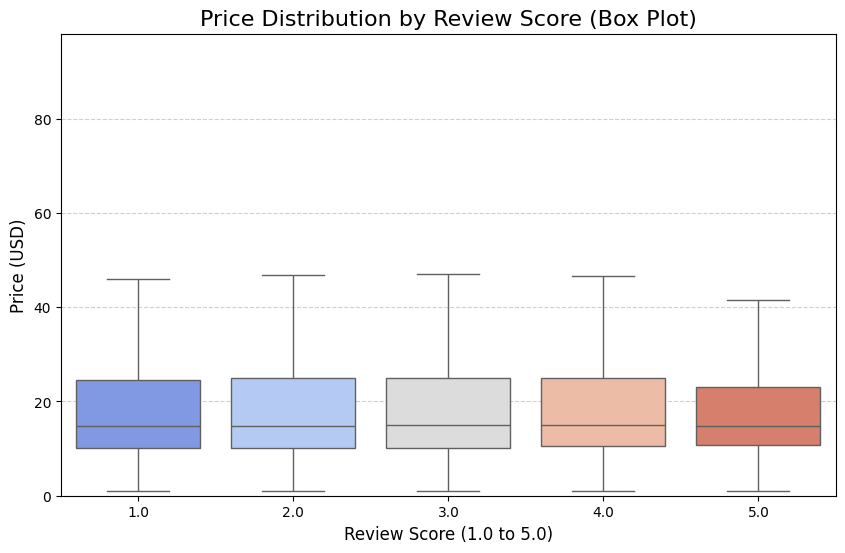

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, when, regexp_replace, round, count

# --- 1. Data Cleaning e Conversione ---

# Assicuriamo che 'Price' e 'review/score' siano tipi numerici puliti.

# 1.1 Conversione di Price (Assumiamo che sia una stringa e abbia bisogno di pulizia,
#    es. se contiene il simbolo del dollaro '$' o virgole)

df_analysis = df_rating.withColumn(
    "Clean_Price",
    regexp_replace(col("Price"), "[$,]", "").cast("float")
)

# 1.2 Conversione di review/score
df_analysis = df_analysis.withColumn(
    "Clean_Score",
    col("review/score").cast("float")
)

# 1.3 Filtra i dati non validi: Rimuove righe con Price o Score mancanti/invalidi.
# Inoltre, filtriamo i prezzi pari a zero, che spesso indicano dati mancanti o gratuiti non rilevanti.
df_clean_for_plot = df_analysis.filter(
    (col("Clean_Price").isNotNull()) &
    (col("Clean_Price") > 0) & # Esclude i prezzi pari a zero
    (col("Clean_Score").isNotNull())
)

# --- 2. Downsampling e Conversione a Pandas ---

# ATTENZIONE: Con 3 milioni di righe, la conversione diretta fallirà su Colab.
# Dobbiamo campionare i dati (Downsampling) per il plotting.
# Campioniamo 100,000 righe, che è un campione statisticamente robusto.

SAMPLE_SIZE = 100000
sampling_fraction = SAMPLE_SIZE / df_clean_for_plot.count()

# Nota: Il campionamento con frazione è robusto per grandi dataset.
df_sample_pd = df_clean_for_plot.sample(fraction=sampling_fraction, seed=42).toPandas()

# --- 3. Generazione del Box Plot ---

plt.figure(figsize=(10, 6))
# Box Plot: y=Prezzo, x=Voto (Score)
sns.boxplot(
    x="Clean_Score",
    y="Clean_Price",
    data=df_sample_pd,
    palette="coolwarm",
    # Limita l'asse Y per visualizzare meglio la maggior parte dei dati,
    # ignorando gli outlier estremi che schiaccerebbero il grafico.
    # Impostiamo il limite Y a un percentile alto (es. 95° o 98° percentile del prezzo)
    showfliers=False # Nasconde gli outlier per una visualizzazione più pulita delle scatole
)

plt.ylim(0, df_sample_pd['Clean_Price'].quantile(0.98)) # Limita l'asse Y al 98° percentile
plt.title('Price Distribution by Review Score (Box Plot)', fontsize=16)
plt.xlabel('Review Score (1.0 to 5.0)', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()